In [2]:
%matplotlib inline

import os
import h5py
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors

from matplotlib.pyplot import figure
from analysis.plots.placecells.F03_place_by_epoch import bootstrapped_epoch_figure
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans
from functools import reduce # only in Python 3

import nbimporter
from Utils import get_bootstrap_statistics, get_bootstrap_shifts, get_bootstrap_raw_lengths, get_colors
#from analysis.processing.utils import get_sessions_list, create_symlinks, get_params_from_json
#from analysis.processing.fields import clean_h5_elements

Importing Jupyter notebook from Utils.ipynb


In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
assets = '/home/andrey/storage2/andrey/data/projects/24_shift/assets'
reports_folder = '/home/andrey/storage2/andrey/data/projects/24_shift/bootstrap'

color_a, color_b, color_c, color_d, color_e = get_colors()

# Bootstrap CI width analysis

In [39]:
where = '/home/andrey/storage2/andrey/data/processed'
animals = ['00908', '00910', '003281', '003282', '003908', '003909']

data_boot = get_bootstrap_statistics(where, animals)
len(data_boot)

9002

In [40]:
columns_boot = [
    'animal',
    'session',
    'exp_type', 
    'epoch',
    'light',
    'isoldist',
    'sic',
    'field',
    'x_mean',
    'y_mean',
    'r_mean',
    'x_CI_low',
    'x_CI_high',
    'y_CI_low',
    'y_CI_high',
    'r_CI_low',
    'r_CI_high',
    'x_std',
    'y_std',
    'r_std',
    'pfr',
    'y_mean_orig',
    'boot_count'
]

df = pd.DataFrame(data_boot, columns=columns_boot)
len(df)

9002

# Bootstrap quality

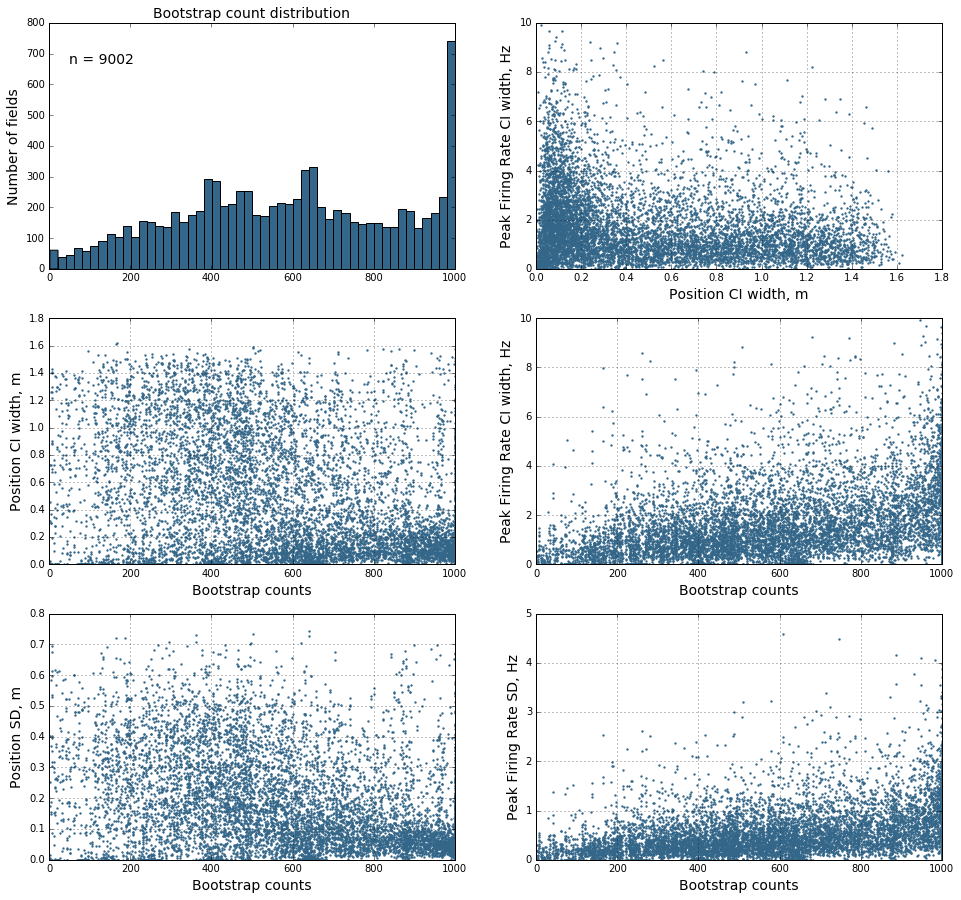

In [41]:
bins = 50
fig = figure(figsize=(16, 15))

# ------- boot count distribution --------------

ax = fig.add_subplot(321)
#ax.set_xlim(-0.4, 0.7)
ax.hist(df['boot_count'], bins, color=color_a)
#ax.set_xlabel('Bootstrap counts', fontsize=14)
ax.set_ylabel('Number of fields', fontsize=14)
ax.text(50, 0.9 * np.histogram(df['boot_count'], bins)[0].max(), 'n = %d' % len(df['boot_count']), fontsize=14)
ax.set_title('Bootstrap count distribution', fontsize=14)


# -------- position CI width vs rate CI width ---------

CI_widths_p = np.array(df['y_CI_high'] - df['y_CI_low'])  # CI widths
CI_widths_r = np.array(df['r_CI_high'] - df['r_CI_low'])  # CI widths
ax = fig.add_subplot(322)
ax.set_xlim(0, 1.8)
ax.set_ylim(0, 10)
ax.set_ylabel('Peak Firing Rate CI width, Hz', fontsize=14)
ax.set_xlabel('Position CI width, m', fontsize=14)
ax.grid()
ax.scatter(CI_widths_p, CI_widths_r, s=2, alpha=0.9, color=color_a)


# -------- boot count vs position CI width ---------

CI_widths = np.array(df['y_CI_high'] - df['y_CI_low'])  # CI widths
ax = fig.add_subplot(323)
ax.set_xlim(0, 1000)
ax.set_ylim(0, 1.8)
ax.set_ylabel('Position CI width, m', fontsize=14)
ax.set_xlabel('Bootstrap counts', fontsize=14)
ax.grid()
ax.scatter(df['boot_count'], CI_widths, s=2, alpha=0.9, color=color_a)
#ax.set_title('CI width < 0.4 only', fontsize=14)


# -------- boot count vs rate CI width ---------

CI_widths = np.array(df['r_CI_high'] - df['r_CI_low'])  # CI widths
ax = fig.add_subplot(324)
ax.set_xlim(0, 1000)
ax.set_ylim(0, 10)
ax.set_ylabel('Peak Firing Rate CI width, Hz', fontsize=14)
ax.set_xlabel('Bootstrap counts', fontsize=14)
ax.grid()
ax.scatter(df['boot_count'], CI_widths, s=2, alpha=0.9, color=color_a)


# -------- boot count vs position SD ---------

ax = fig.add_subplot(325)
ax.set_xlim(0, 1000)
ax.set_ylim(0, 0.8)
ax.set_ylabel('Position SD, m', fontsize=14)
ax.set_xlabel('Bootstrap counts', fontsize=14)
ax.grid()
ax.scatter(df['boot_count'], df['y_std'], s=2, alpha=0.9, color=color_a)
#ax.set_title('CI width < 0.4 only', fontsize=14)


# -------- boot count vs rate SD ---------

CI_widths = np.array(df['r_CI_high'] - df['r_CI_low'])  # CI widths
ax = fig.add_subplot(326)
ax.set_xlim(0, 1000)
ax.set_ylim(0, 5)
ax.set_ylabel('Peak Firing Rate SD, Hz', fontsize=14)
ax.set_xlabel('Bootstrap counts', fontsize=14)
ax.grid()
ax.scatter(df['boot_count'], df['r_std'], s=2, alpha=0.9, color=color_a)


# SD of bootstrapped fields

In [42]:
# ------- position SDs vs position CI width -------
x = np.array(df['y_std'])
y = np.array(df['y_CI_high'] - df['y_CI_low'])  # CI widths

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x1, y1, z1 = x[idx], y[idx], z[idx]

# ------- position SD vs peak firing rate SD -------
x = np.array(df['y_std'])
y = np.array(df['r_std'])

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]

# ------- position vs peak firing rate SD -------
x = np.array(df['y_mean'])
y = np.array(df['r_std'])

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x3, y3, z3 = x[idx], y[idx], z[idx]

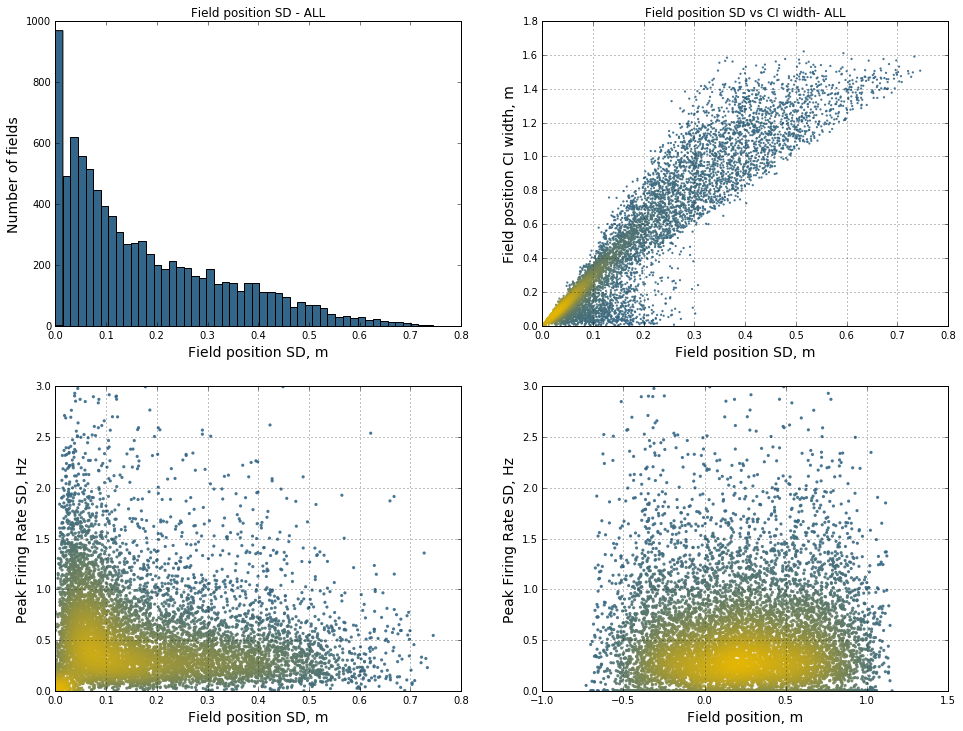

In [48]:
fig = figure(figsize=(16, 12))

# ------- histogram of all position SDs -------

ax = fig.add_subplot(221)
ax.hist(np.array(df['y_std']), 50, color=color_a)
#ax.set_xlim(0, 2.0)
ax.set_xlabel('Field position SD, m', fontsize=14)
ax.set_ylabel('Number of fields', fontsize=14)
ax.set_title('Field position SD - ALL')
#ax.text(0.2, 0.9 * np.histogram(CI_widths, bins)[0].max(), 'n = %d' % len(CI_widths), fontsize=14)

# ------- position SDs vs position CI width -------

cvals  = [z1.min(), z1.max()]
colors = [color_a, color_d]

norm = plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

ax = fig.add_subplot(222)
ax.set_ylim(0, 1.8)
ax.set_xlim(0, 0.8)
ax.set_xlabel('Field position SD, m', fontsize=14)
ax.set_ylabel('Field position CI width, m', fontsize=14)
ax.grid()
ax.scatter(x1, y1, s=5, alpha=0.9, c=z1, cmap=cmap, norm=norm, edgecolor='')
ax.set_title('Field position SD vs CI width- ALL')

# ------- position SD vs peak firing rate SD -------

cvals  = [z2.min(), z2.max()]
colors = [color_a, color_d]

norm = plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

ax = fig.add_subplot(223)
ax.set_ylim(0, 3)
ax.set_xlim(0, 0.8)
ax.set_xlabel('Field position SD, m', fontsize=14)
ax.set_ylabel('Peak Firing Rate SD, Hz', fontsize=14)
ax.grid()
ax.scatter(x2, y2, s=10, alpha=0.9, c=z2, cmap=cmap, norm=norm, edgecolor='')
#ax.set_title('Field position SD vs CI width- ALL')

# ------- position SD vs peak firing rate SD -------

cvals  = [z3.min(), z3.max()]
colors = [color_a, color_d]

norm = plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

ax = fig.add_subplot(224)
ax.set_ylim(0, 3)
#ax.set_xlim(0, 0.8)
ax.set_xlabel('Field position, m', fontsize=14)
ax.set_ylabel('Peak Firing Rate SD, Hz', fontsize=14)
ax.grid()
ax.scatter(x3, y3, s=10, alpha=0.9, c=z3, cmap=cmap, norm=norm, edgecolor='')
#ax.set_title('Field position SD vs CI width- ALL')


filename = "bootstrap_SD_statistics.png"
fig.savefig(os.path.join(os.path.join(reports_folder), filename))

## Bootstrap CI width distribution ALL / Light periods only

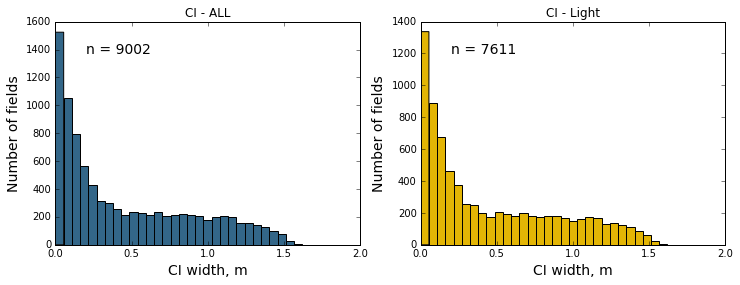

In [90]:
bins = 30

fig = figure(figsize=(12, 4))

# ------- histogram of all CI widths -------

CI_widths = np.array(df['y_CI_high'] - df['y_CI_low'])
ax = fig.add_subplot(121)
ax.hist(CI_widths, bins, color=color_a)
ax.set_xlim(0, 2.0)
ax.set_xlabel('CI width, m', fontsize=14)
ax.set_ylabel('Number of fields', fontsize=14)
ax.set_title('CI - ALL')
ax.text(0.2, 0.9 * np.histogram(CI_widths, bins)[0].max(), 'n = %d' % len(CI_widths), fontsize=14)

# ------- histogram of CI widths in light -------

df_l = df[df['light'] == 'L']  # only fields in light
CI_widths = np.array(df_l['y_CI_high'] - df_l['y_CI_low'])
ax = fig.add_subplot(122)
ax.hist(CI_widths, bins, color=color_d)
ax.set_xlim(0, 2.0)
ax.set_xlabel('CI width, m', fontsize=14)
ax.set_ylabel('Number of fields', fontsize=14)
ax.set_title('CI - Light')
ax.text(0.2, 0.9 * np.histogram(CI_widths, bins)[0].max(), 'n = %d' % len(CI_widths), fontsize=14)


filename = "CI_width_histogram.png"
fig.savefig(os.path.join(os.path.join(reports_folder), filename))

## Bootstrap CI width distribution by experiment type

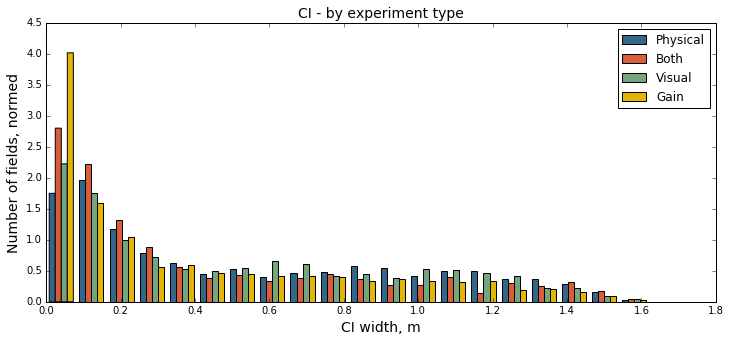

In [91]:
bins = 20

fig = figure(figsize=(12, 5))

# ------- histogram of CI widths by session type -------

df_l = df[df['exp_type'] == 'SP']
CI_widths_SP = np.array(df_l['y_CI_high'] - df_l['y_CI_low'])
df_l = df[df['exp_type'] == 'SPd']
CI_widths_SP = np.concatenate([CI_widths_SP, np.array(df_l['y_CI_high'] - df_l['y_CI_low'])])

df_l = df[df['exp_type'] == 'SB']
CI_widths_SB = np.array(df_l['y_CI_high'] - df_l['y_CI_low'])
df_l = df[df['exp_type'] == 'SBd']
CI_widths_SB = np.concatenate([CI_widths_SB, np.array(df_l['y_CI_high'] - df_l['y_CI_low'])])

df_l = df[df['exp_type'] == 'SV']
CI_widths_SV = np.array(df_l['y_CI_high'] - df_l['y_CI_low'])

df_l = df[df['exp_type'] == 'G3']
CI_widths_G3 = np.array(df_l['y_CI_high'] - df_l['y_CI_low'])

to_plot = [CI_widths_SP, CI_widths_SB, CI_widths_SV, CI_widths_G3]

h_colors = (color_a, color_b, color_c, color_d)
h_labels = ('Physical', 'Both', 'Visual', 'Gain')
ax = fig.add_subplot(111)
ax.hist(to_plot, bins, normed=True, histtype='bar', color=h_colors, label=h_labels)
ax.set_xlim(0, 1.8)
ax.set_xlabel('CI width, m', fontsize=14)
ax.set_ylabel('Number of fields, normed', fontsize=14)
ax.set_title('CI - by experiment type', fontsize=14)
ax.legend()


filename = "CI_width_hist_by_exp_type.png"
fig.savefig(os.path.join(os.path.join(reports_folder), filename))

## Bootstrap CI width distribution by animal

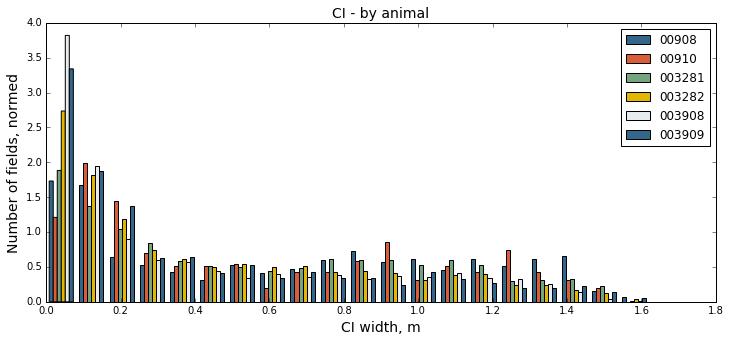

In [92]:
bins = 20

fig = figure(figsize=(12, 5))

to_plot = []
for animal in animals:
    df_l = df[df['animal'] == animal]
    CI_widths = np.array(df_l['y_CI_high'] - df_l['y_CI_low'])
    
    to_plot.append(CI_widths)
    
h_colors = (color_a, color_b, color_c, color_d, color_e, color_a)

ax = fig.add_subplot(111)
ax.hist(to_plot, bins, normed=True, histtype='bar', label=animals, color=h_colors)
ax.set_xlim(0, 1.8)
ax.set_xlabel('CI width, m', fontsize=14)
ax.set_ylabel('Number of fields, normed', fontsize=14)
ax.set_title('CI - by animal', fontsize=14)
ax.legend()


filename = "CI_width_hist_by_animal.png"
fig.savefig(os.path.join(os.path.join(reports_folder), filename))

## Bootstrap Field position / CI width - ALL fields

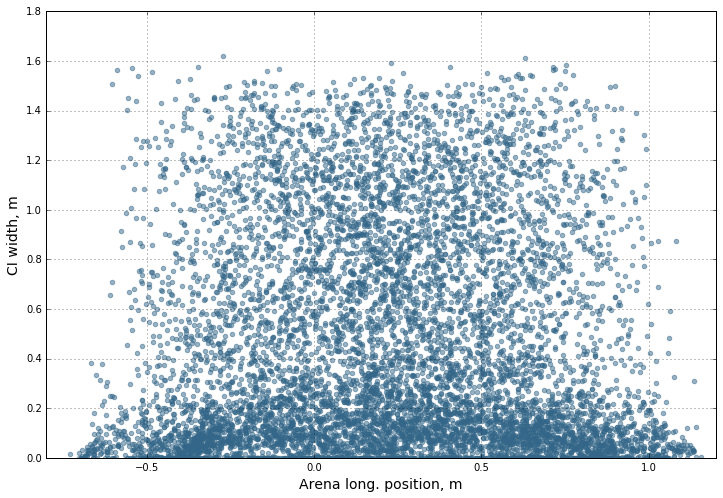

In [93]:
CI_widths = np.array(df['y_CI_high'] - df['y_CI_low'])

fig = figure(figsize=(12, 8))

ax = fig.add_subplot(111)
ax.set_xlim(-0.8, 1.2)
ax.set_ylim(0, 1.8)
ax.set_xlabel('Arena long. position, m', fontsize=14)
ax.set_ylabel('CI width, m', fontsize=14)
ax.scatter(df['y_mean'], CI_widths, alpha=0.5, color=color_a, label='ALL')
ax.grid()


filename = "CI_width_at_field_position_all.png"
fig.savefig(os.path.join(os.path.join(reports_folder), filename))

## Bootstrap Field position / CI width - by animal

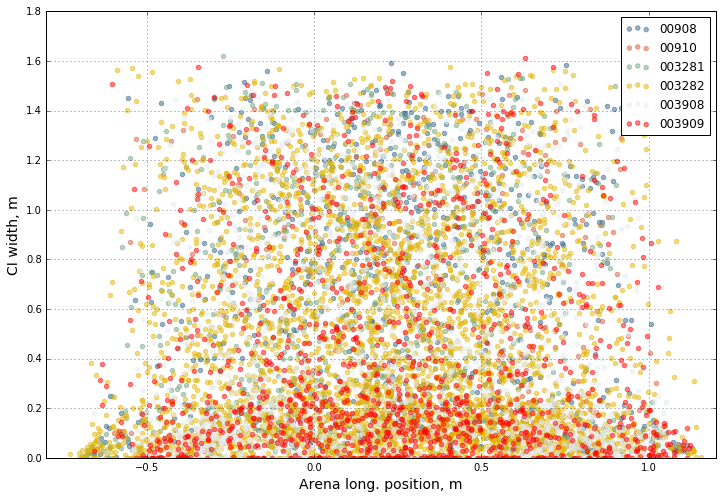

In [94]:
fig = figure(figsize=(12, 8))

ax = fig.add_subplot(111)
ax.set_xlim(-0.8, 1.2)
ax.set_ylim(0, 1.8)
ax.set_xlabel('Arena long. position, m', fontsize=14)
ax.set_ylabel('CI width, m', fontsize=14)
ax.grid()

h_colors = (color_a, color_b, color_c, color_d, color_e, 'red')

for i, animal in enumerate(animals):
    df_l = df[df['animal'] == animal]
    CI_widths = np.array(df_l['y_CI_high'] - df_l['y_CI_low'])
    
    ax.scatter(df_l['y_mean'], CI_widths, alpha=0.5, color=h_colors[i], label=animal)
    
ax.legend()

filename = "CI_width_at_field_position_by_animal.png"
fig.savefig(os.path.join(os.path.join(reports_folder), filename))

## Correlations of CI width with Spatial information (SIC), Peak firing rate (PFR) and Isolation distance


Red lines indicate usual criteria to filter away bad fields:
- spatial information > 0.2
- peak firing rate > 2Hz
- cluster isolation distance > 15

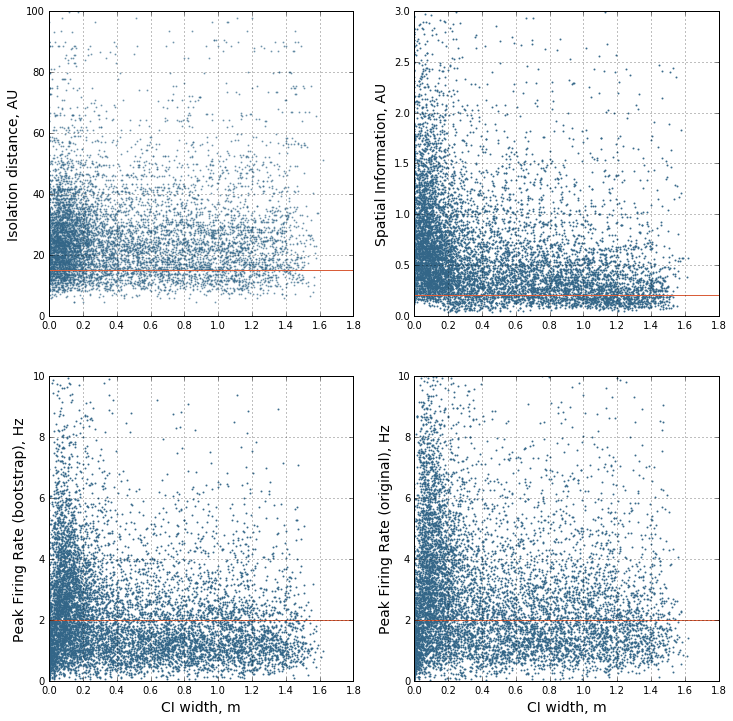

In [95]:
fig = figure(figsize=(12, 12))

CI_widths = np.array(df['y_CI_high'] - df['y_CI_low'])

ax = fig.add_subplot(221)
ax.set_xlim(0, 1.8)
ax.set_ylim(0, 100)
#ax.set_xlabel('CI width, m', fontsize=14)
ax.set_ylabel('Isolation distance, AU', fontsize=14)
ax.grid()
ax.axhline(15, color=color_b)
ax.scatter(CI_widths, df['isoldist'], s=1, alpha=0.5, color=color_a)

ax = fig.add_subplot(222)
ax.set_xlim(0, 1.8)
ax.set_ylim(0, 3)
#ax.set_xlabel('CI width, m', fontsize=14)
ax.set_ylabel('Spatial Information, AU', fontsize=14)
ax.grid()
ax.axhline(0.2, color=color_b)
ax.scatter(CI_widths, df['sic'], s=1, alpha=0.9, color=color_a)

ax = fig.add_subplot(223)
ax.set_xlim(0, 1.8)
ax.set_ylim(0, 10)
ax.set_xlabel('CI width, m', fontsize=14)
ax.set_ylabel('Peak Firing Rate (bootstrap), Hz', fontsize=14)
ax.grid()
ax.axhline(2, color=color_b)
ax.scatter(CI_widths, df['r_mean'], s=1, alpha=0.9, color=color_a)

ax = fig.add_subplot(224)
ax.set_xlim(0, 1.8)
ax.set_ylim(0, 10)
ax.set_xlabel('CI width, m', fontsize=14)
ax.set_ylabel('Peak Firing Rate (original), Hz', fontsize=14)
ax.grid()
ax.axhline(2, color=color_b)
ax.scatter(CI_widths, df['pfr'], s=1, alpha=0.9, color=color_a)

filename = "CI_width_SIC_PFR_ISO.png"
fig.savefig(os.path.join(os.path.join(reports_folder), filename))

## Bootstrapped vs Original Field position and Peak Firing Rate

In [87]:
df_f = df[(df['y_CI_high'] - df['y_CI_low']) < 0.4]

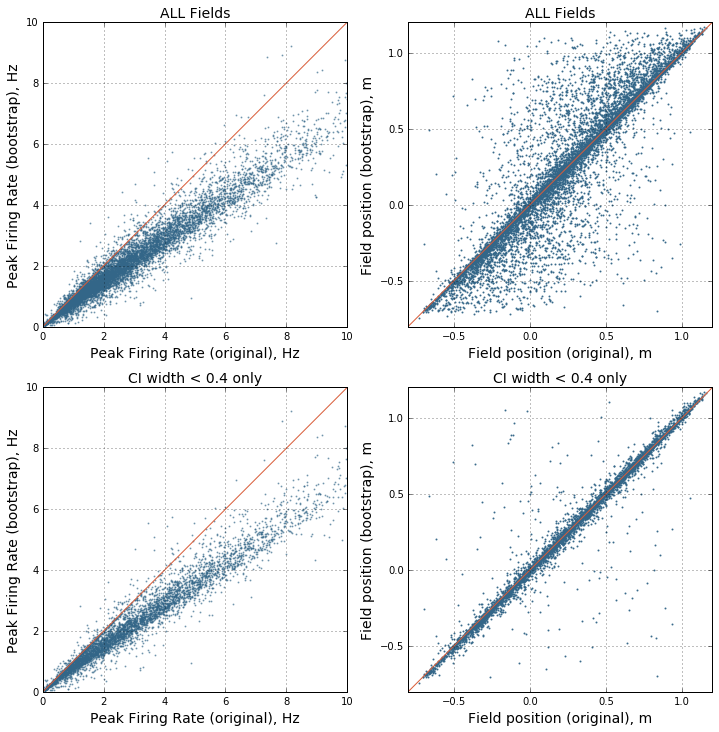

In [96]:
fig = figure(figsize=(12, 12))

# -------- ALL fields -----------------------

no_change_line = np.linspace(0, 10, 10)
ax = fig.add_subplot(221)
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_xlabel('Peak Firing Rate (original), Hz', fontsize=14)
ax.set_ylabel('Peak Firing Rate (bootstrap), Hz', fontsize=14)
ax.grid()
ax.scatter(df['pfr'], df['r_mean'], s=1, alpha=0.5, color=color_a)
ax.plot(no_change_line, no_change_line, color=color_b, label='no change line')
ax.set_title('ALL Fields', fontsize=14)

no_change_line = np.linspace(-0.8, 1.2, 10)
ax = fig.add_subplot(222)
ax.set_xlim(-0.8, 1.2)
ax.set_ylim(-0.8, 1.2)
ax.set_xlabel('Field position (original), m', fontsize=14)
ax.set_ylabel('Field position (bootstrap), m', fontsize=14)
ax.grid()
ax.scatter(df['y_mean'], df['y_mean_orig'], s=1, alpha=0.9, color=color_a)
ax.plot(no_change_line, no_change_line, color=color_b, label='no change line')
ax.set_title('ALL Fields', fontsize=14)

# -------- CI width < 0.4 only -----------------------

no_change_line = np.linspace(0, 10, 10)
ax = fig.add_subplot(223)
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_xlabel('Peak Firing Rate (original), Hz', fontsize=14)
ax.set_ylabel('Peak Firing Rate (bootstrap), Hz', fontsize=14)
ax.grid()
ax.scatter(df_f['pfr'], df_f['r_mean'], s=1, alpha=0.5, color=color_a)
ax.plot(no_change_line, no_change_line, color=color_b, label='no change line')
ax.set_title('CI width < 0.4 only', fontsize=14)

no_change_line = np.linspace(-0.8, 1.2, 10)
ax = fig.add_subplot(224)
ax.set_xlim(-0.8, 1.2)
ax.set_ylim(-0.8, 1.2)
ax.set_xlabel('Field position (original), m', fontsize=14)
ax.set_ylabel('Field position (bootstrap), m', fontsize=14)
ax.grid()
ax.scatter(df_f['y_mean'], df_f['y_mean_orig'], s=1, alpha=0.9, color=color_a)
ax.plot(no_change_line, no_change_line, color=color_b, label='no change line')
ax.set_title('CI width < 0.4 only', fontsize=14)


filename = "PFR_and_field_position_orig_and_boot.png"
fig.savefig(os.path.join(os.path.join(reports_folder), filename))

# Bootstraped shifts distribution

In [4]:
color_a, color_b, color_c, color_d, color_e = get_colors()

where = '/home/andrey/storage2/andrey/data/processed'
animals = ['00908', '00910', '003281', '003282', '003908', '003909']

data_shifts = get_bootstrap_shifts(where, animals, nA='A', nB='B', allowed_types=['SP', 'SPd'])

In [6]:
columns_shifts = [
    'animal',           # 0
    'session',          # 1
    'exp_type',         # 2
    'electrode',        # 3
    'unit',             # 4
    'field_A_id',       # 5
    'field_B_id',       # 6
    'overlap',          # 7
    'distance_img',     # 8
    'distance_real',    # 9
    'len(COMa)',        # 10 number of fields in A
    'len(COMb)',        # 11 number of fields in B
    'peak_FRa',         # 12 peak firing rate A
    'peak_FRb',         # 13 peak firing rate B
    'COMa_x',           # 14
    'COMa_y',           # 15
    'COMb_x',           # 16
    'COMb_y',           # 17
    'sicA',             # 18
    'sicB',             # 19
    'isoldist',         # 20
    'CI_width_a',       # 21
    'CI_width_b',       # 22
    'boot_count_a',     # 24
    'boot_count_b',     # 25
    'CI_width_a_pfr',   # 25
    'CI_width_b_pfr',   # 26
    'SD_y',             # 27
    'SD_pfr'            # 28
]

df_s = pd.DataFrame(data_shifts, columns=columns_shifts)
len(df_s)

962

## Position shift vs Boot counts

In [7]:
# df_s_f - filtered by SIC, Isol distance and PFR
df_s_f = df_s[df_s['sicA'] > 0.2]
df_s_f = df_s_f[df_s_f['sicB'] > 0.2]
df_s_f = df_s_f[df_s_f['isoldist'] > 15]
df_s_f = df_s_f[df_s_f['peak_FRa'] > 2]
df_s_f = df_s_f[df_s_f['peak_FRb'] > 2]

# df_s_ci - filtered by CI width of both A and B < 0.4m
df_s_ci = df_s[df_s['CI_width_a'] < 0.4]
df_s_ci = df_s_ci[df_s_ci['CI_width_b'] < 0.4]

# df_s_f_ci - joint sic / IsoD / PFR / CI width
df_s_f_ci = df_s_f[df_s_f['CI_width_a'] < 0.4]
df_s_f_ci = df_s_f_ci[df_s_f_ci['CI_width_b'] < 0.4]

# remember these are 'A' vs 'B' only of types 'SP' and 'SPd'
shifts_SP = np.array(df_s['distance_real'])
shifts_SP_f = np.array(df_s_f['distance_real'])
shifts_SP_ci = np.array(df_s_ci['distance_real'])
shifts_SP_f_ci = np.array(df_s_f_ci['distance_real'])

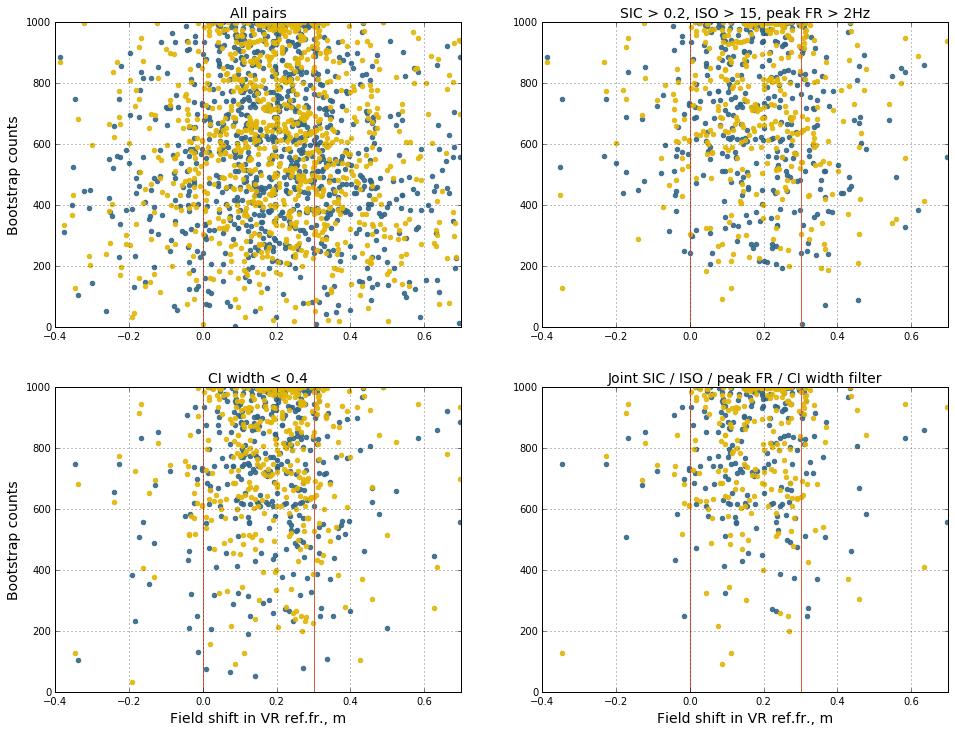

In [9]:
fig = figure(figsize=(16, 12))

ax = fig.add_subplot(221)
ax.set_ylim(0, 1000)
ax.set_xlim(-0.4, 0.7)
#ax.set_xlabel('Field shift in VR ref.fr., m', fontsize=14)
ax.set_ylabel('Bootstrap counts', fontsize=14)
ax.axvline(0, color=color_b)
ax.axvline(0.3, color=color_b)
ax.grid()
ax.scatter(df_s['distance_real'], df_s['boot_count_a'], s=20, alpha=0.9, color=color_a)
ax.scatter(df_s['distance_real'], df_s['boot_count_b'], s=20, alpha=0.9, color=color_d)
ax.set_title('All pairs', fontsize=14)


ax = fig.add_subplot(222)
ax.set_ylim(0, 1000)
ax.set_xlim(-0.4, 0.7)
#ax.set_xlabel('Field shift in VR ref.fr., m', fontsize=14)
#ax.set_ylabel('Bootstrap counts', fontsize=14)
ax.axvline(0, color=color_b)
ax.axvline(0.3, color=color_b)
ax.grid()
ax.scatter(df_s_f['distance_real'], df_s_f['boot_count_a'], s=20, alpha=0.9, color=color_a)
ax.scatter(df_s_f['distance_real'], df_s_f['boot_count_b'], s=20, alpha=0.9, color=color_d)
ax.set_title('SIC > 0.2, ISO > 15, peak FR > 2Hz', fontsize=14)


ax = fig.add_subplot(223)
ax.set_ylim(0, 1000)
ax.set_xlim(-0.4, 0.7)
ax.set_xlabel('Field shift in VR ref.fr., m', fontsize=14)
ax.set_ylabel('Bootstrap counts', fontsize=14)
ax.axvline(0, color=color_b)
ax.axvline(0.3, color=color_b)
ax.grid()
ax.scatter(df_s_ci['distance_real'], df_s_ci['boot_count_a'], s=20, alpha=0.9, color=color_a)
ax.scatter(df_s_ci['distance_real'], df_s_ci['boot_count_b'], s=20, alpha=0.9, color=color_d)
ax.set_title('CI width < 0.4', fontsize=14)


ax = fig.add_subplot(224)
ax.set_ylim(0, 1000)
ax.set_xlim(-0.4, 0.7)
ax.set_xlabel('Field shift in VR ref.fr., m', fontsize=14)
#ax.set_ylabel('Bootstrap counts', fontsize=14)
ax.axvline(0, color=color_b)
ax.axvline(0.3, color=color_b)
ax.grid()
ax.scatter(df_s_f_ci['distance_real'], df_s_f_ci['boot_count_a'], s=20, alpha=0.9, color=color_a)
ax.scatter(df_s_f_ci['distance_real'], df_s_f_ci['boot_count_b'], s=20, alpha=0.9, color=color_d)
ax.set_title('Joint SIC / ISO / peak FR / CI width filter', fontsize=14)

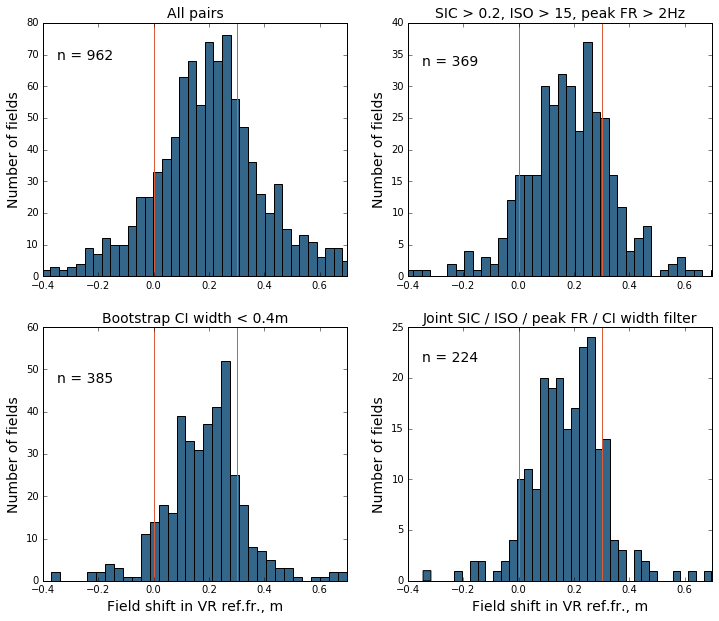

In [10]:
fig = figure(figsize=(12, 10))


bins = 79
ax = fig.add_subplot(221)
ax.set_xlim(-0.4, 0.7)
ax.hist(shifts_SP, bins, color=color_a)
ax.axvline(0, color=color_b)
ax.axvline(0.3, color=color_b)
#ax.set_xlabel('Field shift in VR ref.fr., m', fontsize=14)
ax.set_ylabel('Number of fields', fontsize=14)
ax.text(-0.35, 0.9 * np.histogram(shifts_SP, bins)[0].max(), 'n = %d' % len(shifts_SP), fontsize=14)
ax.set_title('All pairs', fontsize=14)


bins = 52
ax = fig.add_subplot(222)
ax.set_xlim(-0.4, 0.7)
ax.hist(shifts_SP_f, bins, color=color_a)
ax.axvline(0, color=color_b)
ax.axvline(0.3, color=color_b)
#ax.set_xlabel('Field shift in VR ref.fr., m', fontsize=14)
ax.set_ylabel('Number of fields', fontsize=14)
ax.text(-0.35, 0.9 * np.histogram(shifts_SP_f, bins)[0].max(), 'n = %d' % len(shifts_SP_f), fontsize=14)
ax.set_title('SIC > 0.2, ISO > 15, peak FR > 2Hz', fontsize=14)


bins = 59
ax = fig.add_subplot(223)
ax.set_xlim(-0.4, 0.7)
ax.hist(shifts_SP_ci, bins, color=color_a)
ax.axvline(0, color=color_b)
ax.axvline(0.3, color=color_b)
ax.set_xlabel('Field shift in VR ref.fr., m', fontsize=14)
ax.set_ylabel('Number of fields', fontsize=14)
ax.text(-0.35, 0.9 * np.histogram(shifts_SP_ci, bins)[0].max(), 'n = %d' % len(shifts_SP_ci), fontsize=14)
ax.set_title('Filter: bootstrap CI width < 0.4m', fontsize=14)


bins = 37
ax = fig.add_subplot(224)
ax.set_xlim(-0.4, 0.7)
ax.hist(shifts_SP_f_ci, bins, color=color_a)
ax.axvline(0, color=color_b)
ax.axvline(0.3, color=color_b)
ax.set_xlabel('Field shift in VR ref.fr., m', fontsize=14)
ax.set_ylabel('Number of fields', fontsize=14)
ax.text(-0.35, 0.9 * np.histogram(shifts_SP_f_ci, bins)[0].max(), 'n = %d' % len(shifts_SP_f_ci), fontsize=14)
ax.set_title('Joint SIC / ISO / peak FR / CI width filter', fontsize=14)


# ax = fig.add_subplot(224)
# ax.set_xlim(0, 1.6)
# ax.set_ylim(-0.4, 0.7)
# ax.set_xlabel('CI width, m', fontsize=14)
# ax.set_ylabel('Field shift in VR ref.fr., m', fontsize=14)
# ax.axhline(0, color=color_b)
# ax.axhline(0.3, color=color_b)
# ax.grid()
# ax.scatter((df_s['CI_width_a'] + df_s['CI_width_b']) / 2, df_s['distance_real'], s=2, alpha=0.9, color=color_a)
# #ax.set_title('CI width < 0.4 only', fontsize=14)


filename = "Field_shift_hist_with_CI_width.png"
fig.savefig(os.path.join(os.path.join(reports_folder), filename))

## CI / SD for position and firing rate between conditions

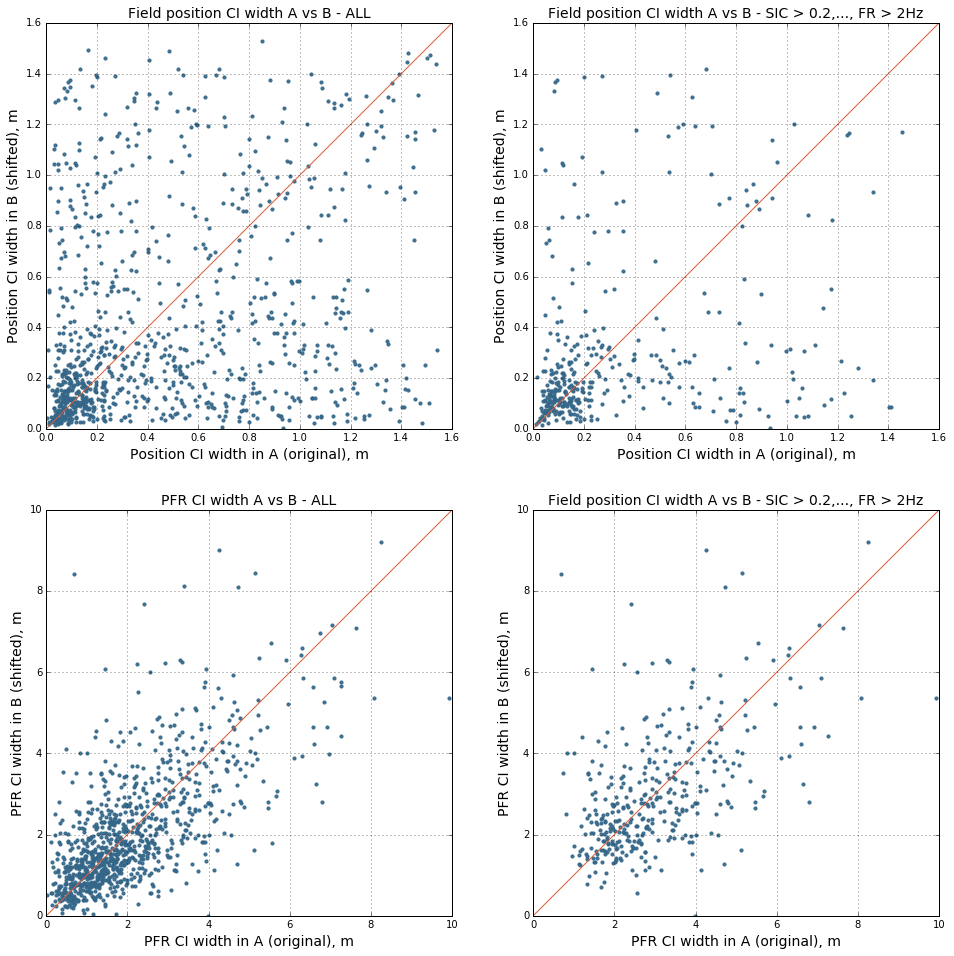

In [34]:
fig = figure(figsize=(16, 16))

no_change_line = np.linspace(0, 10, 10)
ax = fig.add_subplot(221)
ax.set_ylim(0, 1.6)
ax.set_xlim(0, 1.6)
ax.set_xlabel('Position CI width in A (original), m', fontsize=14)
ax.set_ylabel('Position CI width in B (shifted), m', fontsize=14)
ax.grid()
ax.scatter(df_s['CI_width_a'], df_s['CI_width_b'], color=color_a, s=10, alpha=0.9)
ax.plot(no_change_line, no_change_line, color=color_b, label='no change line')
ax.set_title('Field position CI width A vs B - ALL', fontsize=14)


no_change_line = np.linspace(0, 10, 10)
ax = fig.add_subplot(222)
ax.set_ylim(0, 1.6)
ax.set_xlim(0, 1.6)
ax.set_xlabel('Position CI width in A (original), m', fontsize=14)
ax.set_ylabel('Position CI width in B (shifted), m', fontsize=14)
ax.grid()
ax.scatter(df_s_f['CI_width_a'], df_s_f['CI_width_b'], color=color_a, s=10, alpha=0.9)
ax.plot(no_change_line, no_change_line, color=color_b, label='no change line')
ax.set_title('Field position CI width A vs B - SIC > 0.2,..., FR > 2Hz', fontsize=14)



no_change_line = np.linspace(0, 10, 10)
ax = fig.add_subplot(223)
ax.set_ylim(0, 10)
ax.set_xlim(0, 10)
ax.set_xlabel('PFR CI width in A (original), m', fontsize=14)
ax.set_ylabel('PFR CI width in B (shifted), m', fontsize=14)
ax.grid()
ax.scatter(df_s['CI_width_a_pfr'], df_s['CI_width_b_pfr'], color=color_a, s=10, alpha=0.9)
ax.plot(no_change_line, no_change_line, color=color_b, label='no change line')
ax.set_title('PFR CI width A vs B - ALL', fontsize=14)


no_change_line = np.linspace(0, 10, 10)
ax = fig.add_subplot(224)
ax.set_ylim(0, 10)
ax.set_xlim(0, 10)
ax.set_xlabel('PFR CI width in A (original), m', fontsize=14)
ax.set_ylabel('PFR CI width in B (shifted), m', fontsize=14)
ax.grid()
ax.scatter(df_s_f['CI_width_a_pfr'], df_s_f['CI_width_b_pfr'], color=color_a, s=10, alpha=0.9)
ax.plot(no_change_line, no_change_line, color=color_b, label='no change line')
ax.set_title('Field position CI width A vs B - SIC > 0.2,..., FR > 2Hz', fontsize=14)

# Bootstrap quality

In [3]:
where = '/home/andrey/storage2/andrey/data/processed'
animals = ['00908', '00910', '003281', '003282', '003908', '003909']

raw_data_lengths = get_bootstrap_raw_lengths(where, animals)

In [5]:
columns_raw_lengths = [
    'animal',           # 0
    'session',          # 1
    'exp_type',         # 2
    'epoch',            # 3
    'count'             # 4
]

df_raw_l = pd.DataFrame(raw_data_lengths, columns=columns_raw_lengths)
len(df_raw_l)

9002

# Example of custom colormap

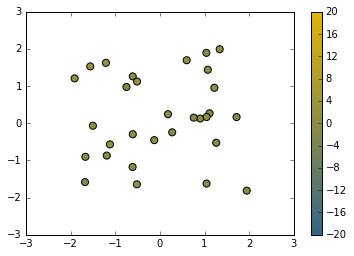

In [6]:
# https://stackoverflow.com/questions/16834861/create-own-colormap-using-matplotlib-and-plot-color-scale

import matplotlib.pyplot as plt
import matplotlib.colors

x,y,c = zip(*np.random.rand(30,3)*4-2)

cvals  = [-20., 20]
colors = [color_a,color_d]

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)

plt.scatter(x,y,c=c, s=50, cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

In [7]:
tuples

[(0.0, '#336688'), (1.0, '#E3B505')]

# Test field plots

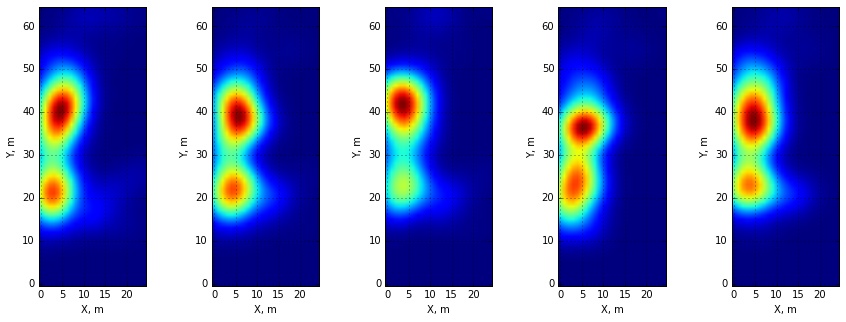

In [4]:
from IPython.display import display, clear_output

h5path = '/home/andrey/storage2/andrey/data/processed/003281/2019-11-21_13-44-47/bootstrap.h5';
fig = figure(figsize=(15, 5))

for i in range(5):
    clear_output(wait=True)
    
    with h5py.File(h5path, 'r') as f:
        pf = np.array(f['4_5']['B']['boot_' + str(i + 200)])

    axA = fig.add_subplot(1, 5, i + 1)
    axA.set_xlabel('X, m')
    axA.set_ylabel('Y, m')
    axA.grid(True)
    posPFA = axA.imshow(pf.T, cmap='jet', origin='lower')

# Clustering sandbox

In [198]:
h5path = '/home/andrey/storage2/andrey/data/processed/003281/2019-11-21_13-44-47/bootstrap.h5';
electrode = 4
unit = 8
conditions = ['A', 'B', 'Ad', 'Bd']
COM_dict = {}
stats_dict = {}

for condition in conditions:
    with h5py.File(h5path, 'r') as f:
        COMs = np.array(f['%s_%s' % (electrode, unit)][condition]['COMs'])

    stats = np.array([0, 0, 0, 0, 0])
    boot_count = 1000
    for i in range (boot_count):
        selected = COMs[COMs[:,0] == i]

        fields_count = len(selected) if len(selected) < 5 else 4
        stats[fields_count] += 1

    COM_dict[condition] = COMs
    stats_dict[condition] = stats
    print("Condition %s: %s" % (condition, stats))

Condition A: [  1 436 562   1   0]
Condition B: [  1 666 331   2   0]
Condition Ad: [  1 761 231   7   0]
Condition Bd: [  1 793 202   4   0]


## K-means

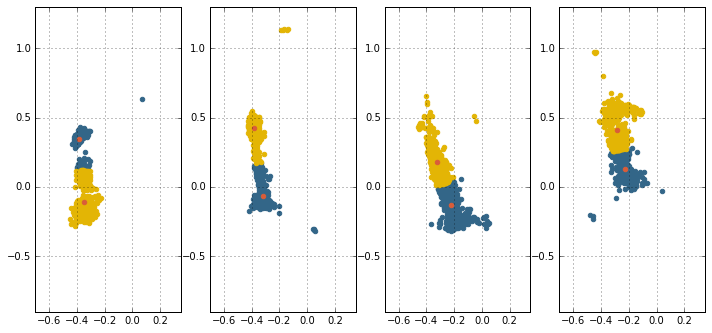

In [199]:
fig = figure(figsize=(3 * len(conditions), 6))

for i, condition in enumerate(conditions):
    clu_count = 2 if stats_dict[condition][2] > 100 else 1
    
    kmeans = KMeans(n_clusters=clu_count).fit(COM_dict[condition][:,2:4])
    KMCs = kmeans.cluster_centers_

    clu1 = COM_dict[condition][kmeans.labels_ == 0]
    
    ax = fig.add_subplot(1, len(conditions), i + 1)
    ax.scatter(clu1[:,2], clu1[:,3], color=color_a)
    ax.set_aspect('equal')
    ax.set_xlim(-0.7, 0.35)
    ax.set_ylim(-0.9, 1.3)
    ax.grid()
    
    if clu_count > 1:
        clu2 = COM_dict[condition][kmeans.labels_ == 1]
        ax.scatter(clu2[:,2], clu2[:,3], color=color_d)

    ax.scatter(KMCs[:, 0], KMCs[:, 1], color=color_b)        

## DBSCAN

3 14
8.79 716 0.037
6.42 574 0.024
7.2 261 0.048
2 20
9.75 970 0.091
5.78 346 0.042
2 53
8.6 1181 0.17
6.02 12 0.014
2 46
9.47 952 0.116
8.07 212 0.04


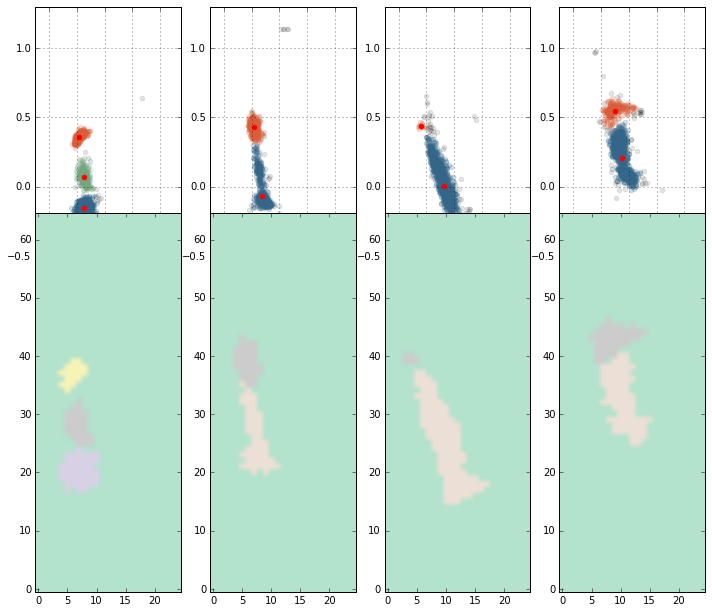

In [244]:
from sklearn.cluster import DBSCAN

colors = [color_a, color_b, color_c, color_d, color_e, color_a, color_b, color_c, color_d, color_e]
fig = figure(figsize=(3 * len(conditions), 16))
with h5py.File(h5path, 'r') as f:
    xy_range = np.array(f['%s_%s' % (electrode, unit)].attrs['xy_range'])


for j, condition in enumerate(conditions):
    
    # ------------ clustering ----------------
    
    db = DBSCAN(eps=0.03, min_samples=10).fit(COM_dict[condition][:,2:4])
    labels = db.labels_

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    # number of clusters == number of fields
    print(n_clusters_, n_noise_)  # need to save these

    ax = fig.add_subplot(1, len(conditions), j + 1)
    ax.set_aspect('equal')
    ax.set_xlim(-0.7, 0.35)
    ax.set_ylim(-0.9, 1.3)
    ax.grid()

    for i in range(n_clusters_):
        clu = COM_dict[condition][labels == i]
        if len(clu) < 100:  # skip clusters with less than 100 bootstrap resamples
            continue
        
        ax.scatter(clu[:,2], clu[:,3], alpha=0.2, color=colors[i])

        # center of masses
        com_x = np.array([x[2] * x[4] for x in clu]).sum() / clu[:, 4].sum()
        com_y = np.array([x[3] * x[4] for x in clu]).sum() / clu[:, 4].sum()

        # peak firing rate
        print(
            com_x,                         # X center of mass of this cluster
            com_y,                         # Y center of mass of this cluster
            round(clu[:, 4].mean(), 3),    # mean PFR of this cluster
            round(np.std(clu[:, 2]), 4),   # SD for bootstraped COMs for X position
            round(np.std(clu[:, 3]), 4),   # SD for bootstraped COMs for Y position
            round(np.std(clu[:, 4]), 4),   # SD for bootstraped PFR
            len(clu),                      # number of points in this cluster
            len(n_noise_),                 # length of noise
        )

        ax.scatter(com_x, com_y, color='red')
        
    clu = COM_dict[condition][labels == -1]
    ax.scatter(clu[:,2], clu[:,3], alpha=0.1, color='black')
    
    # ------------ patches ----------------
    
    with h5py.File(h5path, 'r') as f:
        shape = np.array(f['%s_%s' % (electrode, unit)][condition]['boot_1']).shape
    
    x_space = np.linspace(xy_range[0], xy_range[1], shape[0] + 1)
    y_space = np.linspace(xy_range[2], xy_range[3], shape[1] + 1)
    
    ax2 = fig.add_subplot(2, len(conditions), j + 5)
    
    f_map = np.zeros(shape)
    for i in range(n_clusters_):
        clu = COM_dict[condition][labels == i]

        points = []
        for record in clu:
            x_idx = np.abs(x_space - record[2]).argmin()
            x_bin_no = x_idx if record[2] > x_space[x_idx] else x_idx - 1
            y_idx = np.abs(y_space - record[3]).argmin()
            y_bin_no = y_idx if record[3] > y_space[y_idx] else y_idx - 1
            
            if not (x_bin_no, y_bin_no) in points:
                points.append((x_bin_no, y_bin_no))

        points = np.array(points)
        for idx in points:
            f_map[idx[0]][idx[1]] = i + 1

    # save f_map as "fields" dataset
    ax2.imshow(f_map.T, cmap='Pastel2', origin='lower')


## Getting patches based on bootstraped COMs

In [235]:
for j, condition in enumerate(conditions):
    with h5py.File(h5path, 'r') as f:
        shape = np.array(f['%s_%s' % (electrode, unit)][condition]['boot_1']).shape
    
    x_space = np.linspace(xy_range[0], xy_range[1], shape[0] + 1)
    y_space = np.linspace(xy_range[2], xy_range[3], shape[1] + 1)
    
    val = 0.13
    idx = np.abs(x_space - val).argmin()
    bin_no = idx if val > x_space[idx] else idx - 1
    
    print(x_space, bin_no)

[-0.55435118 -0.52441785 -0.49448452 -0.46455119 -0.43461786 -0.40468453
 -0.3747512  -0.34481787 -0.31488454 -0.2849512  -0.25501787 -0.22508454
 -0.19515121 -0.16521788 -0.13528455 -0.10535122 -0.07541789 -0.04548456
 -0.01555123  0.01438211  0.04431544  0.07424877  0.1041821   0.13411543
  0.16404876  0.19398209] 22
[-0.55435118 -0.52441785 -0.49448452 -0.46455119 -0.43461786 -0.40468453
 -0.3747512  -0.34481787 -0.31488454 -0.2849512  -0.25501787 -0.22508454
 -0.19515121 -0.16521788 -0.13528455 -0.10535122 -0.07541789 -0.04548456
 -0.01555123  0.01438211  0.04431544  0.07424877  0.1041821   0.13411543
  0.16404876  0.19398209] 22
[-0.55435118 -0.52441785 -0.49448452 -0.46455119 -0.43461786 -0.40468453
 -0.3747512  -0.34481787 -0.31488454 -0.2849512  -0.25501787 -0.22508454
 -0.19515121 -0.16521788 -0.13528455 -0.10535122 -0.07541789 -0.04548456
 -0.01555123  0.01438211  0.04431544  0.07424877  0.1041821   0.13411543
  0.16404876  0.19398209] 22
[-0.55435118 -0.52441785 -0.49448452 

# Plot bootstrapped fields and clusters

In [3]:
s_path = '/home/andrey/storage2/andrey/data/processed/003909/2020-03-27_18-41-37/'

bootstrapped_epoch_figure(s_path)

2020-03-27_18-41-37: el 1 unit 10 figure created
2020-03-27_18-41-37: el 1 unit 2 figure created
2020-03-27_18-41-37: el 1 unit 3 figure created
2020-03-27_18-41-37: el 1 unit 4 figure created
2020-03-27_18-41-37: el 1 unit 5 figure created
2020-03-27_18-41-37: el 1 unit 6 figure created
2020-03-27_18-41-37: el 1 unit 7 figure created
2020-03-27_18-41-37: el 1 unit 8 figure created
2020-03-27_18-41-37: el 1 unit 9 figure created
2020-03-27_18-41-37: el 2 unit 10 figure created
2020-03-27_18-41-37: el 2 unit 11 figure created
2020-03-27_18-41-37: el 2 unit 12 figure created
2020-03-27_18-41-37: el 2 unit 13 figure created
2020-03-27_18-41-37: el 2 unit 14 figure created
2020-03-27_18-41-37: el 2 unit 2 figure created
2020-03-27_18-41-37: el 2 unit 3 figure created
2020-03-27_18-41-37: el 2 unit 4 figure created
2020-03-27_18-41-37: el 2 unit 5 figure created
2020-03-27_18-41-37: el 2 unit 6 figure created
2020-03-27_18-41-37: el 2 unit 7 figure created
2020-03-27_18-41-37: el 2 unit 8 f

In [12]:
# TEST if any bootstrap sample has incorrect FR!!
h5path = os.path.join(s_path, 'bootstrap.h5')

with h5py.File(h5path, 'r') as f:
    fields = np.array(f['1_4']['A']['fields'])
    COMs_clusters = np.array(f['1_4']['A']['clusters'])
    


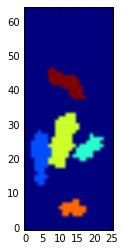

In [8]:
plt.imshow(fields.T, origin='lower')

In [17]:
COMs_clusters[:, 7], COMs_clusters[:, 0]

(array([499., 153., 329., 275., 296.]), array([1., 2., 3., 4., 5.]))

In [20]:
sort_idxs = np.argsort(COMs_clusters[:, 7])[::-1]
field_ids = COMs_clusters[sort_idxs][:2][:, 0]

sort_idxs, field_ids

(array([0, 2, 4, 3, 1]), array([1., 3.]))

In [21]:
COMs_clusters[sort_idxs][:, 7], COMs_clusters[sort_idxs][:, 0]

(array([499., 329., 296., 275., 153.]), array([1., 3., 5., 4., 2.]))